In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/beta_kl_coeff3/agents')

100%|██████████| 640/640 [00:55<00:00, 11.56it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2",
          "InvertedDoublePendulum-v2"]
code_level_opts = {
      #"kl_penalty_coeff": [0.1, 1, 3, 10],
      "kl_penalty_direction": ["new_to_old", "old_to_new"],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
#metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

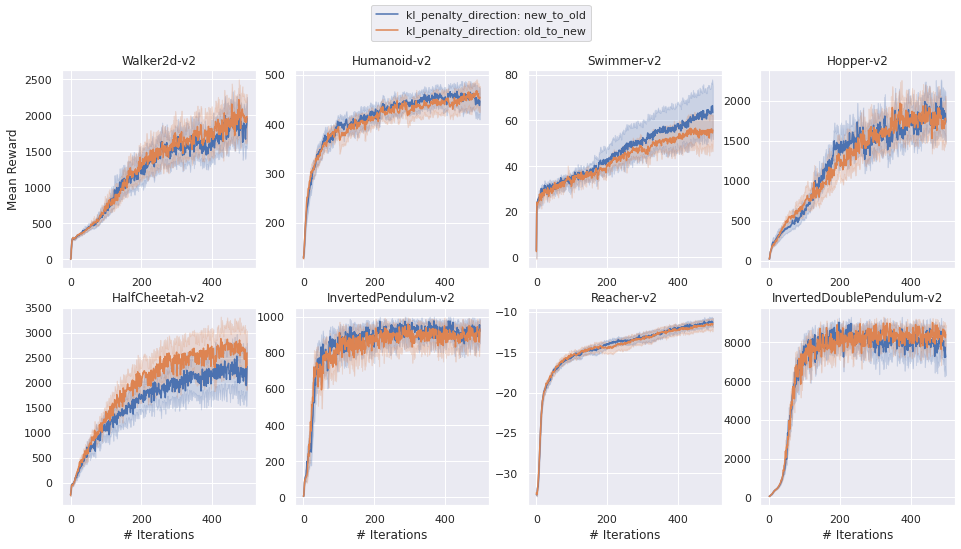

In [7]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot distribution of max rewards

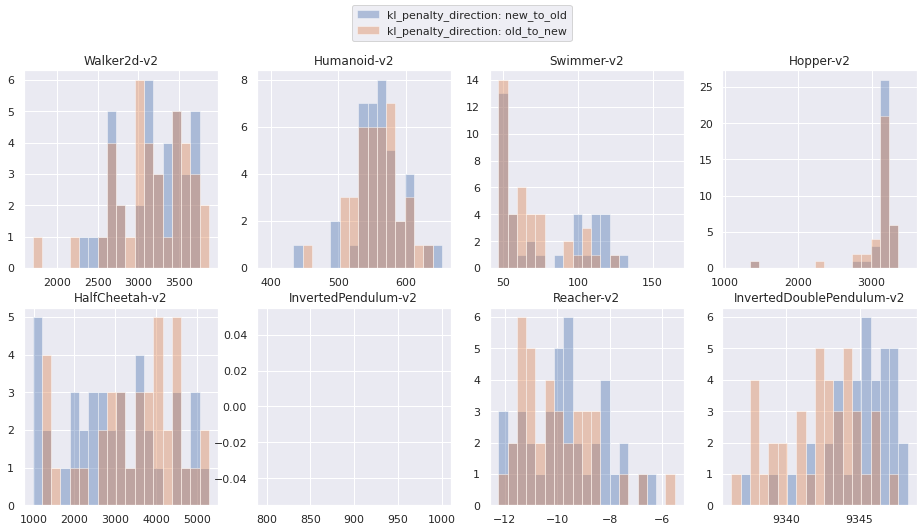

In [6]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [8]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [9]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  mean_max_reward  \
game                      kl_penalty_direction                           
HalfCheetah-v2            new_to_old                0      2975.016227   
                          old_to_new                1      3435.655887   
Hopper-v2                 new_to_old                2      3019.085968   
                          old_to_new                3      2989.034515   
Humanoid-v2               new_to_old                4       563.911920   
                          old_to_new                5       553.204640   
InvertedDoublePendulum-v2 new_to_old                6      9345.095947   
                          old_to_new                7      9342.074156   
InvertedPendulum-v2       new_to_old                8      1000.000000   
                          old_to_new                9       994.837500   
Reacher-v2                new_to_old               10        -9.755082   
                          old_to_new               11       -10.009039   
Swimmer-v2                new_to_old               12        79.186495   
                          old_to_new               13        67.706297   
Walker2d-v2               new_to_old               14      3144.948184   
                          old_to_new               15      3187.655509   

                                                     stddev  max_max_reward  \
game                      kl_penalty_direction                                
HalfCheetah-v2            new_to_old            1259.069116     5413.951595   
                          old_to_new            1229.104305     5413.951595   
Hopper-v2                 new_to_old             544.112403     3556.824305   
                          old_to_new             564.815343     3556.824305   
Humanoid-v2               new_to_old              40.482661      660.660351   
                          old_to_new              44.761101      660.660351   
InvertedDoublePendulum-v2 new_to_old               2.495845     9348.585557   
                          old_to_new               2.887457     9348.585557   
InvertedPendulum-v2       new_to_old               0.000000     1000.000000   
                          old_to_new              32.650517     1000.000000   
Reacher-v2                new_to_old               1.547171       -5.346438   
                          old_to_new               1.660709       -5.346438   
Swimmer-v2                new_to_old              32.570023      167.976421   
                          old_to_new              21.079150      167.976421   
Walker2d-v2               new_to_old             468.628467     3923.964844   
                          old_to_new             473.886178     3923.964844   

                                                min_max_reward  \
game                      kl_penalty_direction                   
HalfCheetah-v2            new_to_old                859.060772   
                          old_to_new                859.060772   
Hopper-v2                 new_to_old               1022.420980   
                          old_to_new               1022.420980   
Humanoid-v2               new_to_old                385.228858   
                          old_to_new                385.228858   
InvertedDoublePendulum-v2 new_to_old               9335.949510   
                          old_to_new               9335.949510   
InvertedPendulum-v2       new_to_old                793.500000   
                          old_to_new                793.500000   
Reacher-v2                new_to_old                -12.417631   
                          old_to_new                -12.417631   
Swimmer-v2                new_to_old                 43.450956   
                          old_to_new                 43.450956   
Walker2d-v2               new_to_old               1644.651659   
                          old_to_new               1644.651659   

                                                normalized_score  \
game                      kl_penalt